<a href="https://colab.research.google.com/github/majedrifat/models/blob/master/bangla_font_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
!unzip font_patch1.zip

Archive:  font_patch1.zip
   creating: font_patch/
   creating: font_patch/adorsolipi/
  inflating: font_patch/adorsolipi/1 (11).png  
  inflating: font_patch/adorsolipi/1 (12).png  
  inflating: font_patch/adorsolipi/1 (15).png  
  inflating: font_patch/adorsolipi/1 (16).png  
  inflating: font_patch/adorsolipi/1 (3).png  
  inflating: font_patch/adorsolipi/1 (4).png  
  inflating: font_patch/adorsolipi/1 (5).png  
  inflating: font_patch/adorsolipi/1 (6).png  
 extracting: font_patch/adorsolipi/3 (56).png  
  inflating: font_patch/adorsolipi/3 (57).png  
  inflating: font_patch/adorsolipi/3 (66).png  
  inflating: font_patch/adorsolipi/3 (67).png  
 extracting: font_patch/adorsolipi/3 (78).png  
 extracting: font_patch/adorsolipi/3 (79).png  
   creating: font_patch/kalpurush/
 extracting: font_patch/kalpurush/1 (143).png  
  inflating: font_patch/kalpurush/1 (213).png  
  inflating: font_patch/kalpurush/1 (214).png  
 extracting: font_patch/kalpurush/1 (4).png  
  inflating: font_pa

In [0]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

In [0]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [0]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [0]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   

In [0]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

In [0]:
data_path = "/content/font_patch/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [0]:

def conv_label(label):
    if label == 'adorsolipi':
        return 0
    elif label == 'kalpurush':
        return 1
    elif label == 'lohit':
        return 2
    elif label == 'nikosh':
        return 3
    elif label == 'rupali':
        return 4
    elif label == 'solaimanlipi':
        return 5
    elif label == 'sonar_bangla':
        return 6

In [10]:
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

for i in list(a): 
    print(list(i))

['blur', 'noise', 'affine', 'gradient']


In [11]:
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    augument=["noise","blur","affine","gradient"]
    for l in range(0,len(augument)):
    
        a=itertools.combinations(augument, l+1)

        for i in list(a): 
            combinations=list(i)
            print(len(combinations))
            temp_img = pil_img
            for j in combinations:
            
                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)
                    
                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    #imshow(blur_img)
                    
    
                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)

1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2


In [12]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

Success


In [0]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

trainY = np.array(trainY)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(trainY)
trainY = to_categorical(vec, num_classes=7)

In [0]:
# convert the labels from integers to vectors
from sklearn.preprocessing import LabelEncoder
import numpy as np

testY = np.array(testY)

label_encoder = LabelEncoder()
vec2 = label_encoder.fit_transform(testY)
testY = to_categorical(vec2, num_classes=7)

In [0]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [0]:
K.common.image_dim_ordering()
K.common.set_image_dim_ordering('tf')

In [0]:
 def create_model():
        model=Sequential()
        # Cu Layers 
        model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
        model.add(UpSampling2D(size=(2, 2)))

        model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
        model.add(UpSampling2D(size=(2, 2)))

        #Cs Layers
        model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

        model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

        model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

        model.add(Flatten())

        model.add(Dense(4096, activation='relu'))

        model.add(Dropout(0.5))

        model.add(Dense(4096,activation='relu'))

        model.add(Dropout(0.5))

        model.add(Dense(2383,activation='relu'))

        model.add(Dense(7, activation='softmax'))
        return model

In [0]:
batch_size = 128
epochs = 50
model= create_model()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [0]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [25]:
model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Train on 1440 samples, validate on 480 samples
Epoch 1/50
1440/1440 [==============================] - 17s 12ms/step - loss: 0.1229 - accuracy: 0.1708 - val_loss: 0.1223 - val_accuracy: 0.1771

Epoch 00001: val_loss improved from inf to 0.12235, saving model to top_model.h5
Epoch 2/50
1440/1440 [==============================] - 3s 2ms/step - loss: 0.1206 - accuracy: 0.2069 - val_loss: 0.1223 - val_accuracy: 0.2042

Epoch 00002: val_loss improved from 0.12235 to 0.12232, saving model to top_model.h5
Epoch 3/50
1440/1440 [==============================] - 3s 2ms/step - loss: 0.1181 - accuracy: 0.2604 - val_loss: 0.1222 - val_accuracy: 0.1771

Epoch 00003: val_loss improved from 0.12232 to 0.12224, saving model to top_model.h5
Epoch 4/50
1440/1440 [==============================] - 3s 2ms/step - loss: 0.1117 - accuracy: 0.3438 - val_loss: 0.1221 - val_accuracy: 0.1521

Epoch 00004: val_loss improved from 0.12224 to 0.12214, saving model to top_model.h5
Epoch 5/50
1440/1440 [=============

In [26]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0057983114167655
Test accuracy: 0.96875


In [0]:
from keras.models import load_model
model = load_model('top_model.h5')

In [28]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0057983114167655
Test accuracy: 0.96875


In [0]:
img_path="/content/1 (1).png"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)

In [0]:
def rev_conv_label(label):
    if label == 0 :
        return 'adorsolipi'
    elif label == 1:
        return 'kalpurush'
    elif label == 2 :
        return 'lohit'
    elif label == 3 :
        return 'nikosh'
    elif label == 4 :
        return 'rupali'
    elif label == 5 :
        return 'solaimanlipi'
    elif label == 6 :
        return 'sonar_bangla'


In [0]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [0]:
y = model.predict_classes(data)

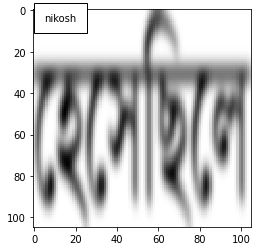

In [104]:
label = rev_conv_label(int(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()